In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as dataset

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
ROOT = '.data'
train_data = dataset.MNIST(root=ROOT, train=True, download=True)

# 정규화
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(mean)
print(std)

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 41389252.66it/s]


Extracting .data\MNIST\raw\train-images-idx3-ubyte.gz to .data\MNIST\raw


100%|██████████| 28881/28881 [00:00<00:00, 28883093.42it/s]


Extracting .data\MNIST\raw\train-labels-idx1-ubyte.gz to .data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 15803597.68it/s]

Extracting .data\MNIST\raw\t10k-images-idx3-ubyte.gz to .data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting .data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .data\MNIST\raw



tensor(0.1307)
tensor(0.3081)


In [3]:
# RandomRotation(5) : 이미지 회전, +-5도 사이
# RandomCrop : padding2 추가 후, 28x28 crop

train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [5]:
train_data = dataset.MNIST(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = dataset.MNIST(root=ROOT, train=True, download=True, transform=test_transforms)
print(len(train_data), len(test_data))

60000 60000


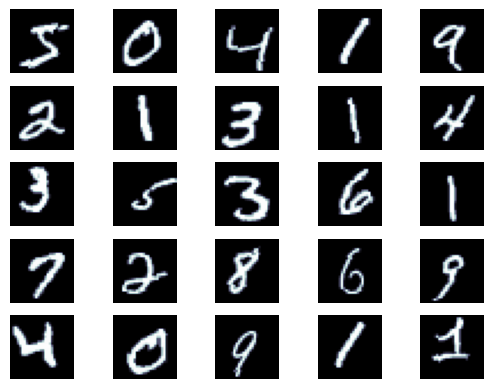

In [6]:
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

N_IMAGES=25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [7]:
#validation 10%
VALID_RATIO = 0.9
n_train_ex = int(len(train_data)*VALID_RATIO)
n_valid_ex = len(train_data) - n_train_ex

train_data, valid_data = data.random_split(train_data, [n_train_ex, n_valid_ex])
print(len(train_data), len(valid_data), len(test_data))

54000 6000 60000


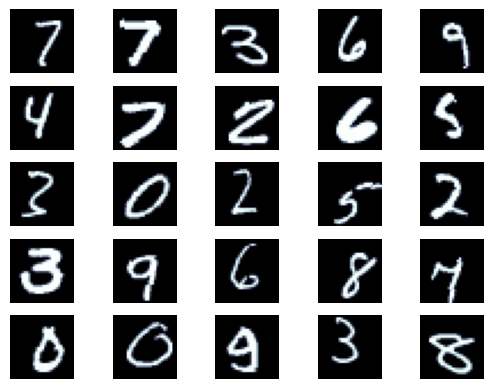

In [8]:
N_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
# to double check we've correctly replaced the training transforms, 
# we can view the same set of images and notice how they're more central 
# (no random cropping) and have a more standard orientation(no random rotations)

In [9]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250,100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2
    

In [11]:
INPUT_DIM = 28*28
OUTPUT_DIM = 10
model = MLP(INPUT_DIM, OUTPUT_DIM)

# we can also create a small function to calculate the number of trainable parameters(weights and biases) in our model
# in case all of our parameters are trainable

# numel() 텐서의 사이즈
# requires_grad = True 자동미분
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

222360


In [12]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in tqdm(iterator, desc='Traning', leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x,y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time-start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
EPOCHS = 3
best_valid_loss = float('inf')   # 양의 무한대(최대값)
for epoch in trange(EPOCHS):
    start_time = time.monotonic()  # 운영체제가 부팅된 이후의 시간(단조시간)  # 타임스탬프 1970.1.1
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}')
    print(f'\tVal Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}')
    

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.173 | Train Acc: 94.73
	Val Loss: 0.116 | Val Acc: 96.29


Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.139 | Train Acc: 95.65
	Val Loss: 0.102 | Val Acc: 96.59


Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.118 | Train Acc: 96.29
	Val Loss: 0.079 | Val Acc: 97.65



In [17]:
# 학습이 완료된 모형 로드
model.load_state_dict(torch.load('mlp-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}')

	Test Loss: 0.068 | Test Acc: 97.92


In [18]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():    # 미분X
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)  # cat: 텐서연결, dim=0 세로방향, dim=1 가로방향
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    
    return images, labels, probs


In [19]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

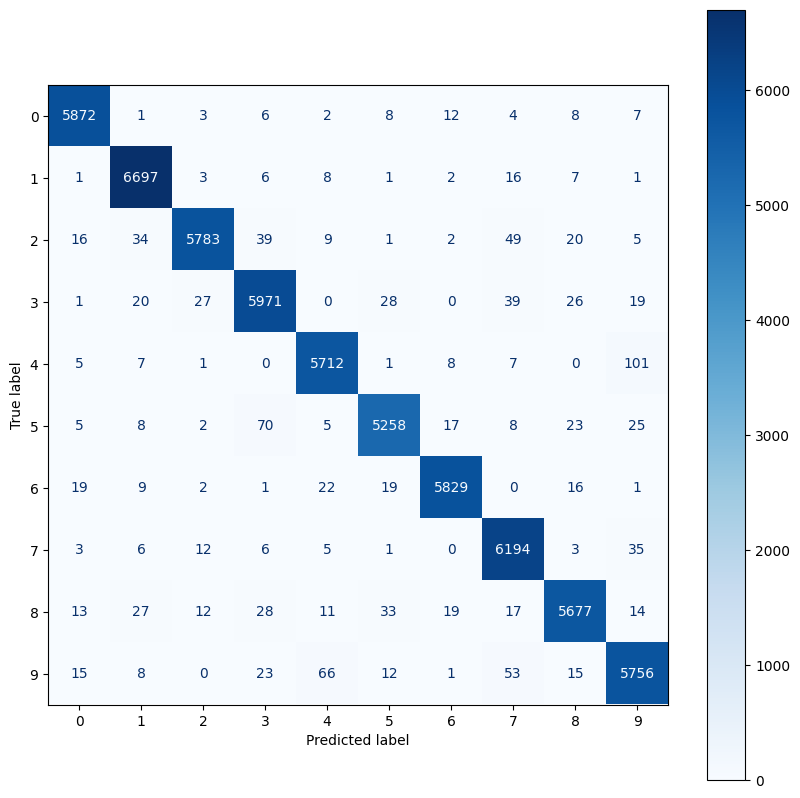

In [20]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)

In [21]:
corrects = torch.eq(labels, pred_labels)
corrects

tensor([True, True, True,  ..., True, True, True])

In [22]:
incorrect_ex = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_ex.append((image, label, prob))
incorrect_ex.sort(reverse=True, key=lambda x:torch.max(x[2], dim=0).values)

In [23]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

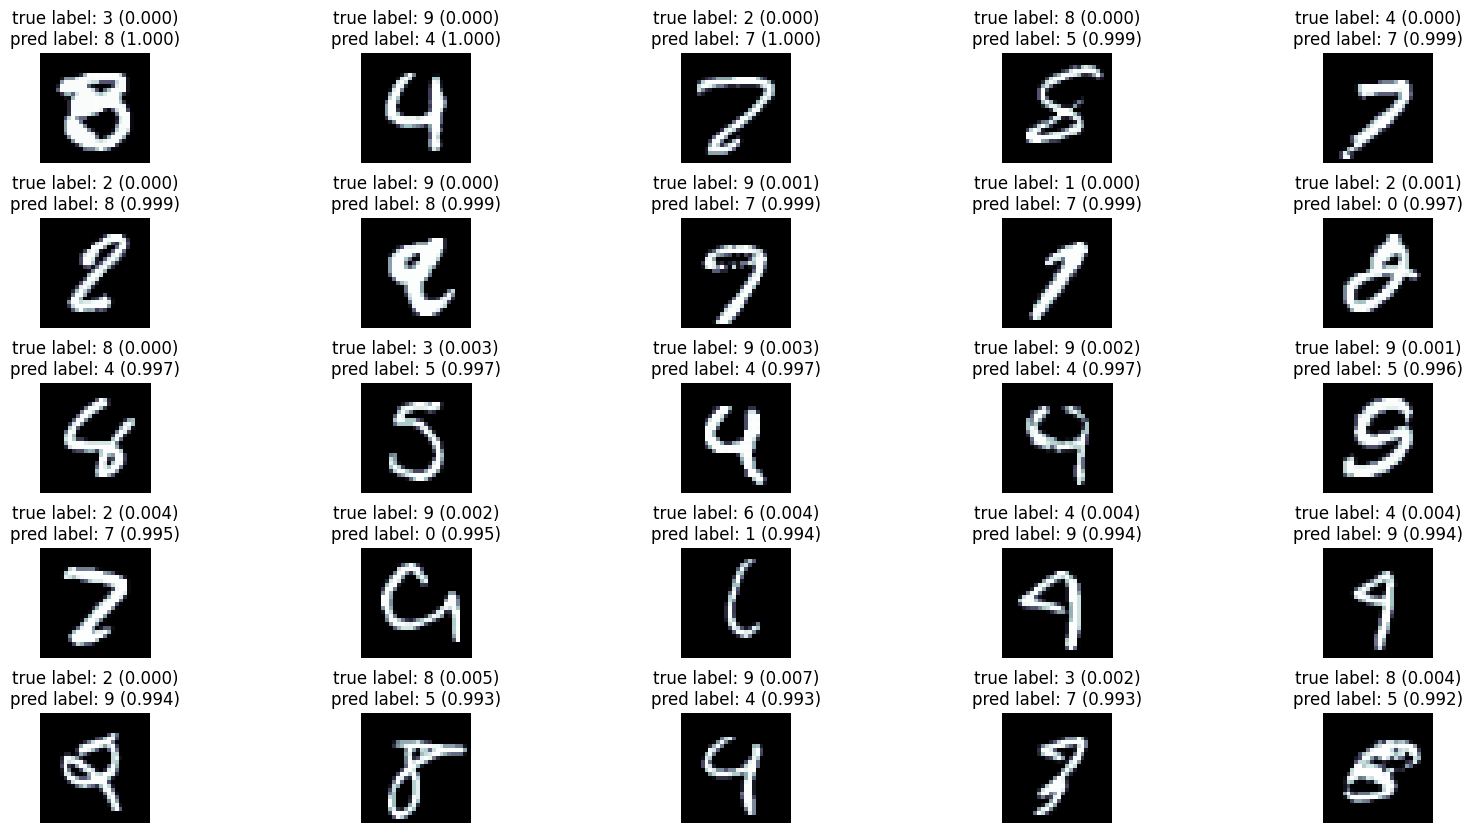

In [26]:
N_IMAGES = 25

plot_most_incorrect(incorrect_ex, N_IMAGES)

In [27]:
def get_representations(model, iterator, device):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            y_pred, h = model(x)
            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
    #최종 출력값
    outputs = torch.cat(outputs, dim=0)
    #출력 직전의 레이어
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)
    return outputs, intermediates, labels


In [28]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

In [29]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data
    
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)



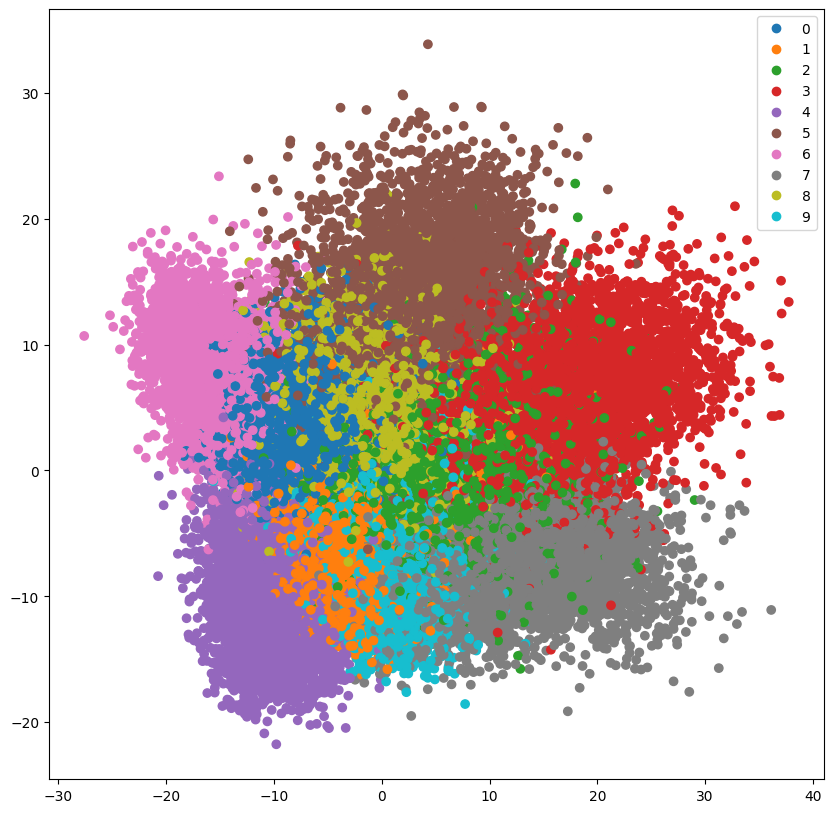

In [30]:
#시각화를 위해 2차원으로 축소(주성분분석)

output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)


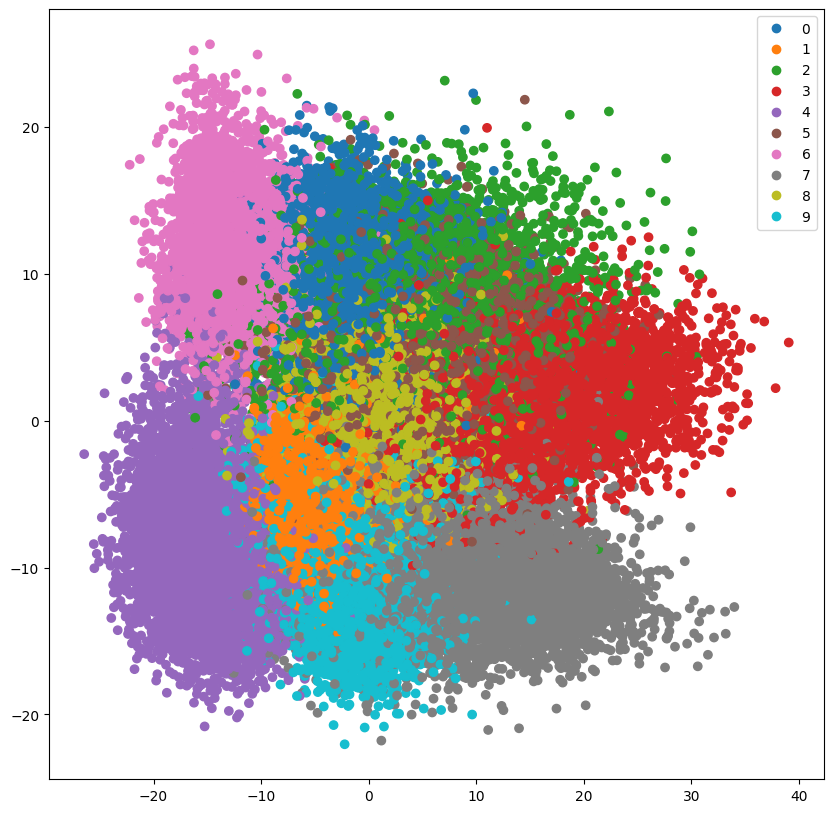

In [31]:
intermediate_pca_data = get_pca(intermediates) #출력 직전의 layer
plot_representations(intermediate_pca_data, labels)

In [32]:
# 좀더 뚜렷하게 시각화하기 위해 t-SNE 사용
# t-SNE (t-distributed stochastic neighbor embedding)
#          t-분포        확률론적   이웃     임베딩
# 거리가 가까운 데이터는 가깝게, 거리가 먼 데이터는 멀리 떨어뜨리는 알고리즘
# t분포 : 자유도 = 표본 수 - 1
# 자유도가 30 이하이면 표준정규분포보다 평평하고, 30이 넘으면 표준 정규분포와 비슷, 120 이상이 되면 표준정규분포와 완전히 같아짐
# 자유도 : 표본집단에서 모집단에 대한 정보를 주는 독립적인 자료의 수
#   5개의 값으로 이뤄진 표본에서 평균과 4개의 값을 알고있다면?
#   데이터 : 2 1 3 5 x, 평균 : 5.5
#   자유도는 ? 4 ( = 5 - 1 )


c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


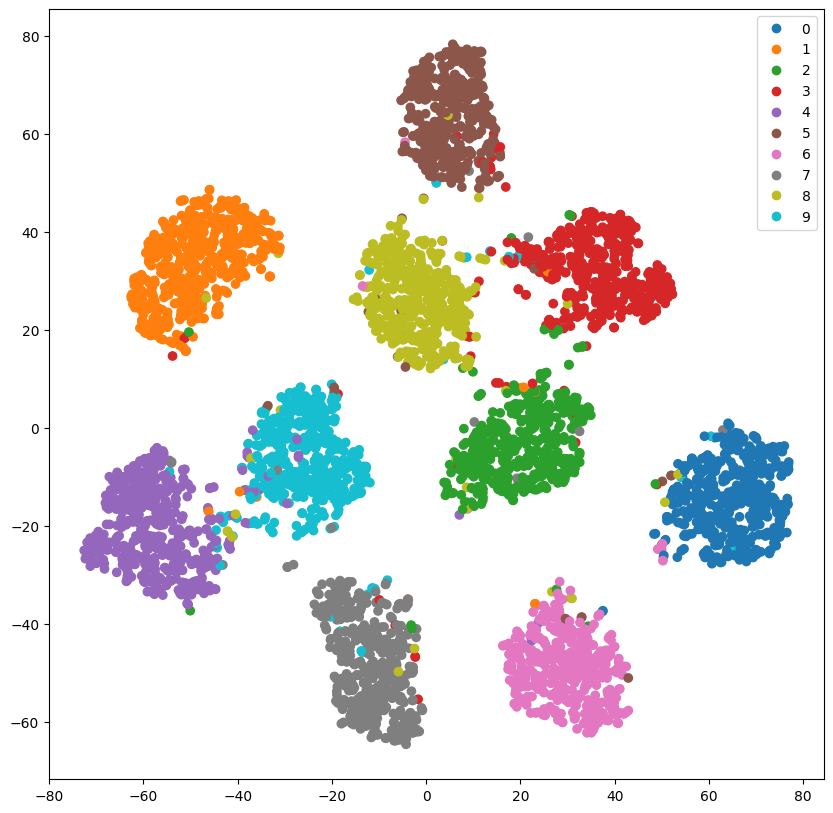

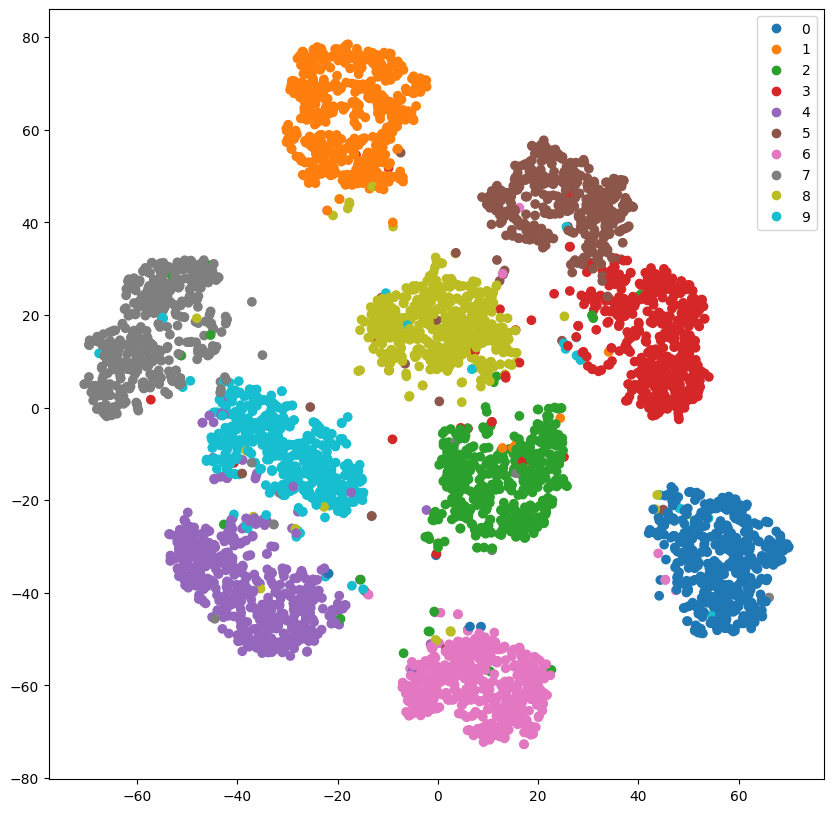

In [33]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

N_IMAGES = 5000
output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)
# 좀더 뚜렷하게 나누어짐

intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)
